In [1]:
from keras.datasets import boston_housing
import numpy as np
from keras import optimizers
from keras import models
from keras import layers

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print(train_data)
# "you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation"
# Called z score.

# >>> a = np.array([[1, 2], [3, 4]])
# >>> np.mean(a, axis=0)   -> Calculates mean.
# array([2., 3.])          -> (1+3)/2
# >>> np.std(a, axis=0)    -> Calculates standard deviation of axis 0.
# array([1.,  1.])         -> ... TODO: add exact calculation example
#
# We should normalize our data, otherwise it is going to be hard for the network to learn. 
# Since some values of the input layer are much larger then others and therefore its harder for the model to adjust the weights to keep the wide spread in "mind".
# We use here https://en.wikipedia.org/wiki/Standard_score
# To archive this we need to aim for 1. and 2. (See further below)

# 1. Goal is to have a "expected value" of 0. https://en.wikipedia.org/wiki/Expected_value
# So basically this will move the x center of input deviation graph to the 0 for all data arrays.
mean = train_data.mean(axis=0)
train_data -= mean
# 2. Goal is to have a "variance" of 1. https://en.wikipedia.org/wiki/Variance
# So basically this will normalize the X axis of the input deviation graph.
# X axis of the input deviation graph will look then like ...-2σ -1σ 0σ 1σ 2σ... σ = standard deviation for all data arrays
std = train_data.std(axis=0) 
train_data /= std

test_data -= mean 
test_data /= std
print(train_data)
print(train_data.std(axis=0)) # As you see its all 1 (Goal 2.)

# Basically we have at the end for every data array the same input model (scale) in form of an array of x, where x represents with x*σ+mean the old value. (σ and mean is different for each axis)
# "normalization helps the backpropagation algorithm converge faster"
# To compare this with the MNIST example.
# Y axis of the input deviation graph is count.
# X axis of the input deviation graph is the gray scale.

# Q: Can't we just map all axis into an range of [-1,+1]? (Min-Max method)?
# A: Yes, but min max method is better for non bell shaped distribution, like MNIST. Because TODO:

[[1.23247e+00 0.00000e+00 8.14000e+00 ... 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 ... 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.75520e+02
  3.26000e+00]
 ...
 [3.46600e-02 3.50000e+01 6.06000e+00 ... 1.69000e+01 3.62250e+02
  7.83000e+00]
 [2.14918e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 2.61950e+02
  1.57900e+01]
 [1.43900e-02 6.00000e+01 2.93000e+00 ... 1.56000e+01 3.76700e+02
  4.38000e+00]]
[[-0.27224633 -0.48361547 -0.43576161 ...  1.14850044  0.44807713
   0.8252202 ]
 [-0.40342651  2.99178419 -1.33391162 ... -1.71818909  0.43190599
  -1.32920239]
 [ 0.1249402  -0.48361547  1.0283258  ...  0.78447637  0.22061726
  -1.30850006]
 ...
 [-0.40202987  0.99079651 -0.7415148  ... -0.71712291  0.07943894
  -0.67776904]
 [-0.17292018 -0.48361547  1.24588095 ... -1.71818909 -0.98764362
   0.42083466]
 [-0.40422614  2.04394792 -1.20161456 ... -1.30866202  0.23317118
  -1.15392266]]
[1. 1. 1. 1. 1. 

In [3]:
def build_model():
    model = models.Sequential() 
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],))) 
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # Regression: the output variable takes continuous values.
    # Classification: the output variable takes class labels.
    # Within regression analysis we try to find the function for continous data. E.g. a simple f(x) = x function.
    # TODO: why mse loss and mae metrics for regression analysis?
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
    return model

In [12]:
# Since we do not have much data we use the k folding approach.
# E.g if we split out data into 3 segments [data][data][data]
# Then we would have 3 iteration:
# 1. [validation data][training data][training data]
# 2. [training data][validation data][training data] 
# 3. [training data][training data][validation data] 
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1)
    print(history.history)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]



processing fold # 0
Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303 [==============================] - 0s 1ms/step - loss: 192.2441 - mae: 10.3309 - val_loss: 37.9975 - val_mae: 4.0681
Epoch 2/500
303/303 [==============================] - 0s 748us/step - loss: 29.8365 - mae: 3.7726 - val_loss: 24.1729 - val_mae: 3.0439
Epoch 3/500
303/303 [==============================] - 0s 779us/step - loss: 20.8449 - mae: 3.0569 - val_loss: 18.4750 - val_mae: 2.6692
Epoch 4/500
303/303 [==============================] - 0s 769us/step - loss: 17.5897 - mae: 2.7772 - val_loss: 16.6840 - val_mae: 2.4758
Epoch 5/500
303/303 [==============================] - 0s 762us/step - loss: 16.4340 - mae: 2.7185 - val_loss: 14.1461 - val_mae: 2.4539
Epoch 6/500
303/303 [==============================] - 0s 774us/step - loss: 15.0285 - mae: 2.6207 - val_loss: 15.1479 - val_mae: 2.3791
Epoch 7/500
303/303 [==============================] - 0s 741us/step - loss: 14.5518 - mae: 2.5306 - val_loss: 1

303/303 [==============================] - 0s 915us/step - loss: 5.6943 - mae: 1.6144 - val_loss: 7.9935 - val_mae: 1.9892
Epoch 61/500
303/303 [==============================] - 0s 735us/step - loss: 5.9626 - mae: 1.6208 - val_loss: 8.0107 - val_mae: 2.0344
Epoch 62/500
303/303 [==============================] - 0s 718us/step - loss: 5.5521 - mae: 1.5129 - val_loss: 7.5436 - val_mae: 1.9592
Epoch 63/500
303/303 [==============================] - 0s 721us/step - loss: 6.1955 - mae: 1.6680 - val_loss: 7.9092 - val_mae: 1.9706
Epoch 64/500
303/303 [==============================] - 0s 709us/step - loss: 5.7950 - mae: 1.5700 - val_loss: 8.3681 - val_mae: 2.1919
Epoch 65/500
303/303 [==============================] - 0s 697us/step - loss: 5.8506 - mae: 1.6528 - val_loss: 8.3755 - val_mae: 2.2163
Epoch 66/500
303/303 [==============================] - 0s 723us/step - loss: 5.5432 - mae: 1.5724 - val_loss: 8.0366 - val_mae: 2.0796
Epoch 67/500
303/303 [==============================] - 0s 75

303/303 [==============================] - 0s 784us/step - loss: 3.9122 - mae: 1.3112 - val_loss: 9.0670 - val_mae: 2.2188
Epoch 121/500
303/303 [==============================] - 0s 705us/step - loss: 3.8791 - mae: 1.3306 - val_loss: 9.1386 - val_mae: 2.1808
Epoch 122/500
303/303 [==============================] - 0s 791us/step - loss: 3.7367 - mae: 1.3281 - val_loss: 12.4299 - val_mae: 2.7730
Epoch 123/500
303/303 [==============================] - 0s 716us/step - loss: 3.7063 - mae: 1.3351 - val_loss: 10.6514 - val_mae: 2.5286
Epoch 124/500
303/303 [==============================] - 0s 705us/step - loss: 3.7381 - mae: 1.3407 - val_loss: 9.6863 - val_mae: 2.3786
Epoch 125/500
303/303 [==============================] - 0s 716us/step - loss: 3.5375 - mae: 1.3070 - val_loss: 9.4226 - val_mae: 2.3870
Epoch 126/500
303/303 [==============================] - 0s 704us/step - loss: 3.3604 - mae: 1.2858 - val_loss: 10.3045 - val_mae: 2.3367
Epoch 127/500
303/303 [=============================

303/303 [==============================] - 0s 717us/step - loss: 2.5361 - mae: 1.1338 - val_loss: 9.8974 - val_mae: 2.3599
Epoch 180/500
303/303 [==============================] - 0s 709us/step - loss: 2.5628 - mae: 1.1022 - val_loss: 16.4776 - val_mae: 3.1216
Epoch 181/500
303/303 [==============================] - 0s 732us/step - loss: 2.2632 - mae: 1.1119 - val_loss: 10.2990 - val_mae: 2.3114
Epoch 182/500
303/303 [==============================] - 0s 742us/step - loss: 2.5771 - mae: 1.1306 - val_loss: 10.2340 - val_mae: 2.3950
Epoch 183/500
303/303 [==============================] - 0s 746us/step - loss: 2.3532 - mae: 1.1146 - val_loss: 10.3809 - val_mae: 2.4807
Epoch 184/500
303/303 [==============================] - 0s 748us/step - loss: 2.5645 - mae: 1.1486 - val_loss: 10.2402 - val_mae: 2.3910
Epoch 185/500
303/303 [==============================] - 0s 739us/step - loss: 2.3151 - mae: 1.1263 - val_loss: 10.5291 - val_mae: 2.3171
Epoch 186/500
303/303 [==========================

303/303 [==============================] - 0s 718us/step - loss: 1.6861 - mae: 0.9560 - val_loss: 10.8072 - val_mae: 2.4236
Epoch 239/500
303/303 [==============================] - 0s 715us/step - loss: 1.6744 - mae: 0.9666 - val_loss: 11.0904 - val_mae: 2.4110
Epoch 240/500
303/303 [==============================] - 0s 730us/step - loss: 1.7092 - mae: 0.9568 - val_loss: 9.2218 - val_mae: 2.1936
Epoch 241/500
303/303 [==============================] - 0s 728us/step - loss: 1.7997 - mae: 0.9805 - val_loss: 10.1700 - val_mae: 2.3391
Epoch 242/500
303/303 [==============================] - 0s 742us/step - loss: 1.7481 - mae: 0.9589 - val_loss: 11.3115 - val_mae: 2.4100
Epoch 243/500
303/303 [==============================] - 0s 735us/step - loss: 1.5879 - mae: 0.9368 - val_loss: 9.3910 - val_mae: 2.2833
Epoch 244/500
303/303 [==============================] - 0s 709us/step - loss: 1.5266 - mae: 0.9052 - val_loss: 12.5360 - val_mae: 2.5808
Epoch 245/500
303/303 [===========================

303/303 [==============================] - 0s 707us/step - loss: 1.2875 - mae: 0.8227 - val_loss: 10.5827 - val_mae: 2.4178
Epoch 298/500
303/303 [==============================] - 0s 709us/step - loss: 1.2217 - mae: 0.8268 - val_loss: 11.3189 - val_mae: 2.5171
Epoch 299/500
303/303 [==============================] - 0s 707us/step - loss: 1.3743 - mae: 0.8361 - val_loss: 11.1069 - val_mae: 2.5580
Epoch 300/500
303/303 [==============================] - 0s 710us/step - loss: 1.5082 - mae: 0.8740 - val_loss: 10.0630 - val_mae: 2.4266
Epoch 301/500
303/303 [==============================] - 0s 730us/step - loss: 1.3554 - mae: 0.8033 - val_loss: 10.0962 - val_mae: 2.4767
Epoch 302/500
303/303 [==============================] - 0s 722us/step - loss: 1.1764 - mae: 0.7980 - val_loss: 9.4503 - val_mae: 2.3446
Epoch 303/500
303/303 [==============================] - 0s 726us/step - loss: 1.4358 - mae: 0.8471 - val_loss: 9.2579 - val_mae: 2.2730
Epoch 304/500
303/303 [===========================

303/303 [==============================] - 0s 727us/step - loss: 1.2367 - mae: 0.7854 - val_loss: 12.1584 - val_mae: 2.5179
Epoch 357/500
303/303 [==============================] - 0s 714us/step - loss: 1.1049 - mae: 0.7733 - val_loss: 10.6148 - val_mae: 2.4749
Epoch 358/500
303/303 [==============================] - 0s 708us/step - loss: 1.0609 - mae: 0.7600 - val_loss: 11.1691 - val_mae: 2.4682
Epoch 359/500
303/303 [==============================] - 0s 716us/step - loss: 1.2286 - mae: 0.7711 - val_loss: 11.7231 - val_mae: 2.4831
Epoch 360/500
303/303 [==============================] - 0s 731us/step - loss: 1.0897 - mae: 0.7635 - val_loss: 10.7087 - val_mae: 2.4951
Epoch 361/500
303/303 [==============================] - 0s 716us/step - loss: 1.0038 - mae: 0.7335 - val_loss: 10.8062 - val_mae: 2.4650
Epoch 362/500
303/303 [==============================] - 0s 740us/step - loss: 1.0211 - mae: 0.7322 - val_loss: 11.4772 - val_mae: 2.4895
Epoch 363/500
303/303 [=========================

303/303 [==============================] - 0s 721us/step - loss: 0.9629 - mae: 0.7066 - val_loss: 9.3122 - val_mae: 2.3319
Epoch 416/500
303/303 [==============================] - 0s 738us/step - loss: 0.9124 - mae: 0.7183 - val_loss: 12.0133 - val_mae: 2.4740
Epoch 417/500
303/303 [==============================] - 0s 755us/step - loss: 0.9527 - mae: 0.6925 - val_loss: 11.7485 - val_mae: 2.4963
Epoch 418/500
303/303 [==============================] - 0s 746us/step - loss: 1.0219 - mae: 0.7459 - val_loss: 11.7128 - val_mae: 2.6352
Epoch 419/500
303/303 [==============================] - 0s 741us/step - loss: 0.8804 - mae: 0.7087 - val_loss: 10.8673 - val_mae: 2.4568
Epoch 420/500
303/303 [==============================] - 0s 735us/step - loss: 0.9976 - mae: 0.7324 - val_loss: 9.8121 - val_mae: 2.3971
Epoch 421/500
303/303 [==============================] - 0s 743us/step - loss: 0.8308 - mae: 0.6749 - val_loss: 10.1198 - val_mae: 2.4675
Epoch 422/500
303/303 [===========================

303/303 [==============================] - 0s 717us/step - loss: 0.9137 - mae: 0.6805 - val_loss: 11.1321 - val_mae: 2.5528
Epoch 475/500
303/303 [==============================] - 0s 737us/step - loss: 0.9857 - mae: 0.7024 - val_loss: 10.5563 - val_mae: 2.4553
Epoch 476/500
303/303 [==============================] - 0s 731us/step - loss: 0.8338 - mae: 0.6833 - val_loss: 11.5941 - val_mae: 2.4777
Epoch 477/500
303/303 [==============================] - 0s 723us/step - loss: 0.7915 - mae: 0.6736 - val_loss: 10.7216 - val_mae: 2.4652
Epoch 478/500
303/303 [==============================] - 0s 885us/step - loss: 0.7927 - mae: 0.6558 - val_loss: 10.2247 - val_mae: 2.4476
Epoch 479/500
303/303 [==============================] - 0s 741us/step - loss: 0.8396 - mae: 0.6641 - val_loss: 11.0014 - val_mae: 2.5326
Epoch 480/500
303/303 [==============================] - 0s 789us/step - loss: 0.9087 - mae: 0.6767 - val_loss: 9.6882 - val_mae: 2.3557
Epoch 481/500
303/303 [==========================

Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303 [==============================] - 0s 1ms/step - loss: 220.9122 - mae: 11.1088 - val_loss: 23.3067 - val_mae: 3.6919
Epoch 2/500
303/303 [==============================] - 0s 707us/step - loss: 27.1138 - mae: 3.4790 - val_loss: 19.4115 - val_mae: 3.3728
Epoch 3/500
303/303 [==============================] - 0s 719us/step - loss: 19.7599 - mae: 2.9694 - val_loss: 15.8217 - val_mae: 3.0137
Epoch 4/500
303/303 [==============================] - 0s 734us/step - loss: 15.3109 - mae: 2.6740 - val_loss: 14.7753 - val_mae: 2.9092
Epoch 5/500
303/303 [==============================] - 0s 740us/step - loss: 13.4645 - mae: 2.4557 - val_loss: 14.3250 - val_mae: 2.8314
Epoch 6/500
303/303 [==============================] - 0s 732us/step - loss: 12.4605 - mae: 2.4222 - val_loss: 14.4741 - val_mae: 2.9090
Epoch 7/500
303/303 [==============================] - 0s 730us/step - loss: 11.8409 - mae: 2.3568 - val_loss: 12.5759 - val_mae: 2.

303/303 [==============================] - 0s 726us/step - loss: 5.4421 - mae: 1.5761 - val_loss: 9.7828 - val_mae: 2.3933
Epoch 61/500
303/303 [==============================] - 0s 726us/step - loss: 5.5635 - mae: 1.5364 - val_loss: 12.1393 - val_mae: 2.6061
Epoch 62/500
303/303 [==============================] - 0s 721us/step - loss: 5.4677 - mae: 1.5852 - val_loss: 11.3953 - val_mae: 2.5701
Epoch 63/500
303/303 [==============================] - 0s 724us/step - loss: 5.3600 - mae: 1.5895 - val_loss: 9.3875 - val_mae: 2.2970
Epoch 64/500
303/303 [==============================] - 0s 734us/step - loss: 5.1863 - mae: 1.5462 - val_loss: 9.7616 - val_mae: 2.4105
Epoch 65/500
303/303 [==============================] - 0s 757us/step - loss: 5.6680 - mae: 1.5510 - val_loss: 10.2174 - val_mae: 2.4088
Epoch 66/500
303/303 [==============================] - 0s 796us/step - loss: 5.1858 - mae: 1.4517 - val_loss: 9.9983 - val_mae: 2.3787
Epoch 67/500
303/303 [==============================] - 0s

Epoch 120/500
303/303 [==============================] - 0s 783us/step - loss: 3.6584 - mae: 1.2186 - val_loss: 19.1295 - val_mae: 2.8369
Epoch 121/500
303/303 [==============================] - 0s 730us/step - loss: 3.3680 - mae: 1.2484 - val_loss: 13.2776 - val_mae: 2.6690
Epoch 122/500
303/303 [==============================] - 0s 725us/step - loss: 3.5560 - mae: 1.2250 - val_loss: 15.6700 - val_mae: 2.7492
Epoch 123/500
303/303 [==============================] - 0s 715us/step - loss: 3.0498 - mae: 1.1638 - val_loss: 24.5541 - val_mae: 3.1866
Epoch 124/500
303/303 [==============================] - 0s 722us/step - loss: 3.2668 - mae: 1.1583 - val_loss: 17.7144 - val_mae: 2.8765
Epoch 125/500
303/303 [==============================] - 0s 727us/step - loss: 3.3148 - mae: 1.2520 - val_loss: 15.0385 - val_mae: 2.7487
Epoch 126/500
303/303 [==============================] - 0s 719us/step - loss: 3.3127 - mae: 1.2339 - val_loss: 15.5817 - val_mae: 2.7186
Epoch 127/500
303/303 [===========

303/303 [==============================] - 0s 726us/step - loss: 2.1919 - mae: 1.0524 - val_loss: 29.3906 - val_mae: 3.4322
Epoch 180/500
303/303 [==============================] - 0s 718us/step - loss: 2.0133 - mae: 0.9937 - val_loss: 32.0535 - val_mae: 3.5338
Epoch 181/500
303/303 [==============================] - 0s 716us/step - loss: 2.1266 - mae: 1.0372 - val_loss: 20.3531 - val_mae: 2.7779
Epoch 182/500
303/303 [==============================] - 0s 730us/step - loss: 2.0157 - mae: 0.9761 - val_loss: 20.2017 - val_mae: 2.9896
Epoch 183/500
303/303 [==============================] - 0s 723us/step - loss: 2.0607 - mae: 0.9940 - val_loss: 22.6178 - val_mae: 3.0759
Epoch 184/500
303/303 [==============================] - 0s 715us/step - loss: 2.1156 - mae: 0.9953 - val_loss: 20.9583 - val_mae: 3.0218
Epoch 185/500
303/303 [==============================] - 0s 711us/step - loss: 2.0142 - mae: 0.9882 - val_loss: 18.9127 - val_mae: 2.9012
Epoch 186/500
303/303 [=========================

303/303 [==============================] - 0s 735us/step - loss: 1.5177 - mae: 0.9388 - val_loss: 34.3315 - val_mae: 3.2976
Epoch 239/500
303/303 [==============================] - 0s 713us/step - loss: 1.5619 - mae: 0.8991 - val_loss: 32.5276 - val_mae: 3.4025
Epoch 240/500
303/303 [==============================] - 0s 711us/step - loss: 1.5738 - mae: 0.9201 - val_loss: 42.9342 - val_mae: 3.7616
Epoch 241/500
303/303 [==============================] - 0s 718us/step - loss: 1.5757 - mae: 0.9073 - val_loss: 28.4854 - val_mae: 3.2402
Epoch 242/500
303/303 [==============================] - 0s 723us/step - loss: 1.5096 - mae: 0.8808 - val_loss: 33.3112 - val_mae: 3.3907
Epoch 243/500
303/303 [==============================] - 0s 714us/step - loss: 1.5094 - mae: 0.9000 - val_loss: 35.9696 - val_mae: 3.4220
Epoch 244/500
303/303 [==============================] - 0s 719us/step - loss: 1.5776 - mae: 0.9370 - val_loss: 40.8391 - val_mae: 3.4765
Epoch 245/500
303/303 [=========================

303/303 [==============================] - 0s 719us/step - loss: 1.1666 - mae: 0.7771 - val_loss: 32.3471 - val_mae: 3.2132
Epoch 298/500
303/303 [==============================] - 0s 741us/step - loss: 1.2585 - mae: 0.8209 - val_loss: 29.1085 - val_mae: 3.1338
Epoch 299/500
303/303 [==============================] - 0s 712us/step - loss: 1.2470 - mae: 0.8235 - val_loss: 29.8729 - val_mae: 3.2052
Epoch 300/500
303/303 [==============================] - 0s 734us/step - loss: 1.0852 - mae: 0.7712 - val_loss: 40.3340 - val_mae: 3.5187
Epoch 301/500
303/303 [==============================] - 0s 717us/step - loss: 1.0555 - mae: 0.7798 - val_loss: 34.5015 - val_mae: 3.3457
Epoch 302/500
303/303 [==============================] - 0s 737us/step - loss: 1.0661 - mae: 0.7702 - val_loss: 34.4909 - val_mae: 3.3223
Epoch 303/500
303/303 [==============================] - 0s 703us/step - loss: 1.2071 - mae: 0.7933 - val_loss: 34.6956 - val_mae: 3.3931
Epoch 304/500
303/303 [=========================

303/303 [==============================] - 0s 713us/step - loss: 1.0130 - mae: 0.7180 - val_loss: 31.5244 - val_mae: 3.2472
Epoch 357/500
303/303 [==============================] - 0s 717us/step - loss: 0.9707 - mae: 0.7051 - val_loss: 29.4334 - val_mae: 3.1907
Epoch 358/500
303/303 [==============================] - 0s 716us/step - loss: 0.9597 - mae: 0.7275 - val_loss: 36.8312 - val_mae: 3.4859
Epoch 359/500
303/303 [==============================] - 0s 710us/step - loss: 1.0150 - mae: 0.7401 - val_loss: 31.8830 - val_mae: 3.3580
Epoch 360/500
303/303 [==============================] - 0s 722us/step - loss: 1.0165 - mae: 0.7341 - val_loss: 29.4672 - val_mae: 3.1468
Epoch 361/500
303/303 [==============================] - 0s 713us/step - loss: 1.0106 - mae: 0.7359 - val_loss: 34.4685 - val_mae: 3.2990
Epoch 362/500
303/303 [==============================] - 0s 708us/step - loss: 0.9901 - mae: 0.7294 - val_loss: 36.7599 - val_mae: 3.4386
Epoch 363/500
303/303 [=========================

303/303 [==============================] - 0s 711us/step - loss: 0.7618 - mae: 0.6599 - val_loss: 29.2943 - val_mae: 3.3238
Epoch 416/500
303/303 [==============================] - 0s 707us/step - loss: 0.9234 - mae: 0.6855 - val_loss: 20.3373 - val_mae: 2.8834
Epoch 417/500
303/303 [==============================] - 0s 723us/step - loss: 0.9395 - mae: 0.7196 - val_loss: 22.7544 - val_mae: 3.0242
Epoch 418/500
303/303 [==============================] - 0s 711us/step - loss: 0.8667 - mae: 0.6784 - val_loss: 21.2774 - val_mae: 2.9562
Epoch 419/500
303/303 [==============================] - 0s 711us/step - loss: 0.8375 - mae: 0.6629 - val_loss: 25.0380 - val_mae: 3.0608
Epoch 420/500
303/303 [==============================] - 0s 708us/step - loss: 0.8495 - mae: 0.7035 - val_loss: 27.4743 - val_mae: 3.1752
Epoch 421/500
303/303 [==============================] - 0s 725us/step - loss: 0.8806 - mae: 0.6809 - val_loss: 26.7673 - val_mae: 3.1630
Epoch 422/500
303/303 [=========================

303/303 [==============================] - 0s 732us/step - loss: 0.8020 - mae: 0.6521 - val_loss: 24.8818 - val_mae: 3.1016
Epoch 475/500
303/303 [==============================] - 0s 727us/step - loss: 0.7980 - mae: 0.6513 - val_loss: 19.8471 - val_mae: 2.9037
Epoch 476/500
303/303 [==============================] - 0s 737us/step - loss: 0.7124 - mae: 0.5982 - val_loss: 24.6735 - val_mae: 3.0716
Epoch 477/500
303/303 [==============================] - 0s 734us/step - loss: 0.8302 - mae: 0.6607 - val_loss: 24.4531 - val_mae: 3.0854
Epoch 478/500
303/303 [==============================] - 0s 745us/step - loss: 0.7857 - mae: 0.6531 - val_loss: 22.0683 - val_mae: 2.8905
Epoch 479/500
303/303 [==============================] - 0s 753us/step - loss: 0.7289 - mae: 0.6413 - val_loss: 23.2443 - val_mae: 2.8987
Epoch 480/500
303/303 [==============================] - 0s 735us/step - loss: 0.7544 - mae: 0.6448 - val_loss: 28.9767 - val_mae: 3.2746
Epoch 481/500
303/303 [=========================

Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303 [==============================] - 0s 1ms/step - loss: 174.8522 - mae: 9.7786 - val_loss: 34.4877 - val_mae: 4.0601
Epoch 2/500
303/303 [==============================] - 0s 709us/step - loss: 25.9737 - mae: 3.5894 - val_loss: 24.7265 - val_mae: 3.1817
Epoch 3/500
303/303 [==============================] - 0s 714us/step - loss: 18.6501 - mae: 2.9261 - val_loss: 18.9500 - val_mae: 2.9170
Epoch 4/500
303/303 [==============================] - 0s 710us/step - loss: 15.9700 - mae: 2.7430 - val_loss: 18.4464 - val_mae: 2.7155
Epoch 5/500
303/303 [==============================] - 0s 713us/step - loss: 13.7509 - mae: 2.5401 - val_loss: 17.6567 - val_mae: 2.6591
Epoch 6/500
303/303 [==============================] - 0s 711us/step - loss: 11.9931 - mae: 2.4081 - val_loss: 19.7682 - val_mae: 2.8888
Epoch 7/500
303/303 [==============================] - 0s 711us/step - loss: 11.7664 - mae: 2.3352 - val_loss: 16.5465 - val_mae: 2.6

303/303 [==============================] - 0s 860us/step - loss: 4.6985 - mae: 1.5068 - val_loss: 13.9912 - val_mae: 2.4805
Epoch 61/500
303/303 [==============================] - 0s 738us/step - loss: 4.5017 - mae: 1.5151 - val_loss: 15.1868 - val_mae: 2.5500
Epoch 62/500
303/303 [==============================] - 0s 751us/step - loss: 4.6038 - mae: 1.5255 - val_loss: 15.0338 - val_mae: 2.5807
Epoch 63/500
303/303 [==============================] - 0s 724us/step - loss: 4.2011 - mae: 1.4644 - val_loss: 14.4868 - val_mae: 2.6328
Epoch 64/500
303/303 [==============================] - 0s 717us/step - loss: 4.1401 - mae: 1.4499 - val_loss: 14.8310 - val_mae: 2.5048
Epoch 65/500
303/303 [==============================] - 0s 710us/step - loss: 4.3578 - mae: 1.4489 - val_loss: 14.3622 - val_mae: 2.5186
Epoch 66/500
303/303 [==============================] - 0s 711us/step - loss: 4.0923 - mae: 1.3891 - val_loss: 15.8559 - val_mae: 2.7407
Epoch 67/500
303/303 [==============================] 

Epoch 120/500
303/303 [==============================] - 0s 711us/step - loss: 2.5638 - mae: 1.1793 - val_loss: 17.4959 - val_mae: 2.7511
Epoch 121/500
303/303 [==============================] - 0s 715us/step - loss: 2.3972 - mae: 1.1543 - val_loss: 17.1045 - val_mae: 2.6945
Epoch 122/500
303/303 [==============================] - 0s 704us/step - loss: 2.5678 - mae: 1.1859 - val_loss: 17.5303 - val_mae: 2.8220
Epoch 123/500
303/303 [==============================] - 0s 706us/step - loss: 2.4394 - mae: 1.1215 - val_loss: 17.4694 - val_mae: 2.7594
Epoch 124/500
303/303 [==============================] - 0s 701us/step - loss: 2.5042 - mae: 1.1849 - val_loss: 17.2837 - val_mae: 2.7630
Epoch 125/500
303/303 [==============================] - 0s 714us/step - loss: 2.6907 - mae: 1.1866 - val_loss: 19.0555 - val_mae: 2.9023
Epoch 126/500
303/303 [==============================] - 0s 712us/step - loss: 2.4090 - mae: 1.1125 - val_loss: 18.2452 - val_mae: 2.7424
Epoch 127/500
303/303 [===========

303/303 [==============================] - 0s 742us/step - loss: 1.7503 - mae: 0.9273 - val_loss: 18.7015 - val_mae: 2.8931
Epoch 180/500
303/303 [==============================] - 0s 712us/step - loss: 1.5998 - mae: 0.9310 - val_loss: 17.8757 - val_mae: 2.8615
Epoch 181/500
303/303 [==============================] - 0s 701us/step - loss: 1.7875 - mae: 0.9708 - val_loss: 17.9173 - val_mae: 2.7513
Epoch 182/500
303/303 [==============================] - 0s 713us/step - loss: 1.5255 - mae: 0.9119 - val_loss: 18.9350 - val_mae: 2.8570
Epoch 183/500
303/303 [==============================] - 0s 709us/step - loss: 1.7949 - mae: 0.9956 - val_loss: 18.2067 - val_mae: 2.8214
Epoch 184/500
303/303 [==============================] - 0s 713us/step - loss: 1.6941 - mae: 0.9308 - val_loss: 18.9747 - val_mae: 2.9175
Epoch 185/500
303/303 [==============================] - 0s 716us/step - loss: 1.6239 - mae: 0.9550 - val_loss: 17.4197 - val_mae: 2.7737
Epoch 186/500
303/303 [=========================

303/303 [==============================] - 0s 717us/step - loss: 1.3154 - mae: 0.8169 - val_loss: 17.1404 - val_mae: 2.7833
Epoch 239/500
303/303 [==============================] - 0s 705us/step - loss: 1.3393 - mae: 0.8452 - val_loss: 17.5394 - val_mae: 2.8300
Epoch 240/500
303/303 [==============================] - 0s 699us/step - loss: 1.3499 - mae: 0.8382 - val_loss: 17.9557 - val_mae: 2.8916
Epoch 241/500
303/303 [==============================] - 0s 718us/step - loss: 1.2640 - mae: 0.8309 - val_loss: 21.1796 - val_mae: 3.2031
Epoch 242/500
303/303 [==============================] - 0s 714us/step - loss: 1.3387 - mae: 0.8056 - val_loss: 18.1344 - val_mae: 2.9282
Epoch 243/500
303/303 [==============================] - 0s 723us/step - loss: 1.2429 - mae: 0.8108 - val_loss: 17.9685 - val_mae: 2.9184
Epoch 244/500
303/303 [==============================] - 0s 710us/step - loss: 1.2027 - mae: 0.7848 - val_loss: 17.3829 - val_mae: 2.8461
Epoch 245/500
303/303 [=========================

303/303 [==============================] - 0s 732us/step - loss: 1.0841 - mae: 0.7540 - val_loss: 18.9547 - val_mae: 2.9833
Epoch 298/500
303/303 [==============================] - 0s 709us/step - loss: 1.0218 - mae: 0.7509 - val_loss: 16.2472 - val_mae: 2.7833
Epoch 299/500
303/303 [==============================] - 0s 722us/step - loss: 1.1189 - mae: 0.7841 - val_loss: 17.6157 - val_mae: 2.8363
Epoch 300/500
303/303 [==============================] - 0s 719us/step - loss: 0.9830 - mae: 0.7260 - val_loss: 17.6628 - val_mae: 2.8669
Epoch 301/500
303/303 [==============================] - 0s 707us/step - loss: 1.0705 - mae: 0.7458 - val_loss: 17.9610 - val_mae: 2.8911
Epoch 302/500
303/303 [==============================] - 0s 700us/step - loss: 1.0194 - mae: 0.7090 - val_loss: 18.2391 - val_mae: 2.9608
Epoch 303/500
303/303 [==============================] - 0s 720us/step - loss: 1.0364 - mae: 0.7392 - val_loss: 18.8967 - val_mae: 3.0194
Epoch 304/500
303/303 [=========================

303/303 [==============================] - 0s 712us/step - loss: 1.0045 - mae: 0.7098 - val_loss: 19.3533 - val_mae: 3.0674
Epoch 357/500
303/303 [==============================] - 0s 720us/step - loss: 0.8540 - mae: 0.6827 - val_loss: 18.1036 - val_mae: 2.9197
Epoch 358/500
303/303 [==============================] - 0s 716us/step - loss: 0.8216 - mae: 0.6439 - val_loss: 19.6282 - val_mae: 3.0387
Epoch 359/500
303/303 [==============================] - 0s 727us/step - loss: 0.8629 - mae: 0.6689 - val_loss: 17.5303 - val_mae: 2.8462
Epoch 360/500
303/303 [==============================] - 0s 711us/step - loss: 0.9157 - mae: 0.6867 - val_loss: 20.0547 - val_mae: 3.1970
Epoch 361/500
303/303 [==============================] - 0s 726us/step - loss: 0.8270 - mae: 0.6843 - val_loss: 18.8735 - val_mae: 3.0181
Epoch 362/500
303/303 [==============================] - 0s 721us/step - loss: 0.7815 - mae: 0.6465 - val_loss: 17.5083 - val_mae: 2.9405
Epoch 363/500
303/303 [=========================

303/303 [==============================] - 0s 704us/step - loss: 0.7318 - mae: 0.6286 - val_loss: 18.3899 - val_mae: 2.9025
Epoch 416/500
303/303 [==============================] - 0s 711us/step - loss: 0.7971 - mae: 0.6419 - val_loss: 18.2522 - val_mae: 2.8964
Epoch 417/500
303/303 [==============================] - 0s 711us/step - loss: 0.7666 - mae: 0.6494 - val_loss: 16.9608 - val_mae: 2.8251
Epoch 418/500
303/303 [==============================] - 0s 705us/step - loss: 0.8549 - mae: 0.6382 - val_loss: 18.8874 - val_mae: 2.9301
Epoch 419/500
303/303 [==============================] - 0s 715us/step - loss: 0.6752 - mae: 0.6130 - val_loss: 20.0116 - val_mae: 3.0383
Epoch 420/500
303/303 [==============================] - 0s 727us/step - loss: 0.8334 - mae: 0.6531 - val_loss: 20.0657 - val_mae: 2.9997
Epoch 421/500
303/303 [==============================] - 0s 721us/step - loss: 0.8893 - mae: 0.6857 - val_loss: 19.5487 - val_mae: 2.9481
Epoch 422/500
303/303 [=========================

303/303 [==============================] - 0s 709us/step - loss: 0.6758 - mae: 0.5854 - val_loss: 19.3334 - val_mae: 3.0248
Epoch 475/500
303/303 [==============================] - 0s 732us/step - loss: 0.6781 - mae: 0.6055 - val_loss: 18.3896 - val_mae: 3.0209
Epoch 476/500
303/303 [==============================] - 0s 717us/step - loss: 0.7866 - mae: 0.6310 - val_loss: 18.3173 - val_mae: 2.9449
Epoch 477/500
303/303 [==============================] - 0s 708us/step - loss: 0.7761 - mae: 0.6347 - val_loss: 17.6537 - val_mae: 2.8794
Epoch 478/500
303/303 [==============================] - 0s 707us/step - loss: 0.7168 - mae: 0.6202 - val_loss: 17.2905 - val_mae: 2.7990
Epoch 479/500
303/303 [==============================] - 0s 706us/step - loss: 0.7281 - mae: 0.6059 - val_loss: 18.0198 - val_mae: 2.9087
Epoch 480/500
303/303 [==============================] - 0s 724us/step - loss: 0.7234 - mae: 0.6081 - val_loss: 18.0537 - val_mae: 2.8913
Epoch 481/500
303/303 [=========================

Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303 [==============================] - 0s 1ms/step - loss: 202.2230 - mae: 10.5519 - val_loss: 65.2403 - val_mae: 5.5408
Epoch 2/500
303/303 [==============================] - 0s 714us/step - loss: 30.7250 - mae: 3.6685 - val_loss: 35.7034 - val_mae: 4.0402
Epoch 3/500
303/303 [==============================] - 0s 701us/step - loss: 21.1670 - mae: 3.0299 - val_loss: 30.3265 - val_mae: 3.5898
Epoch 4/500
303/303 [==============================] - 0s 728us/step - loss: 18.0429 - mae: 2.8030 - val_loss: 25.2920 - val_mae: 3.3016
Epoch 5/500
303/303 [==============================] - 0s 709us/step - loss: 16.0906 - mae: 2.5279 - val_loss: 26.7563 - val_mae: 3.1479
Epoch 6/500
303/303 [==============================] - 0s 712us/step - loss: 14.2043 - mae: 2.4058 - val_loss: 20.6798 - val_mae: 2.7988
Epoch 7/500
303/303 [==============================] - 0s 716us/step - loss: 13.2277 - mae: 2.3295 - val_loss: 21.1932 - val_mae: 2.

303/303 [==============================] - 0s 720us/step - loss: 5.6209 - mae: 1.5193 - val_loss: 10.8582 - val_mae: 2.2975
Epoch 61/500
303/303 [==============================] - 0s 724us/step - loss: 5.4356 - mae: 1.5164 - val_loss: 10.8097 - val_mae: 2.2680
Epoch 62/500
303/303 [==============================] - 0s 726us/step - loss: 5.0691 - mae: 1.4812 - val_loss: 11.8248 - val_mae: 2.4080
Epoch 63/500
303/303 [==============================] - 0s 717us/step - loss: 5.1127 - mae: 1.4970 - val_loss: 13.3448 - val_mae: 2.6007
Epoch 64/500
303/303 [==============================] - 0s 720us/step - loss: 5.4268 - mae: 1.4613 - val_loss: 10.6877 - val_mae: 2.2890
Epoch 65/500
303/303 [==============================] - 0s 722us/step - loss: 4.9675 - mae: 1.4416 - val_loss: 10.5728 - val_mae: 2.2737
Epoch 66/500
303/303 [==============================] - 0s 719us/step - loss: 5.0313 - mae: 1.4633 - val_loss: 11.5365 - val_mae: 2.4948
Epoch 67/500
303/303 [==============================] 

Epoch 120/500
303/303 [==============================] - 0s 704us/step - loss: 3.9661 - mae: 1.2388 - val_loss: 12.9373 - val_mae: 2.6818
Epoch 121/500
303/303 [==============================] - 0s 721us/step - loss: 3.6696 - mae: 1.2156 - val_loss: 13.8248 - val_mae: 2.6500
Epoch 122/500
303/303 [==============================] - 0s 716us/step - loss: 3.5644 - mae: 1.2445 - val_loss: 12.3815 - val_mae: 2.5952
Epoch 123/500
303/303 [==============================] - 0s 715us/step - loss: 3.6814 - mae: 1.2313 - val_loss: 11.4989 - val_mae: 2.3686
Epoch 124/500
303/303 [==============================] - 0s 734us/step - loss: 3.8022 - mae: 1.2060 - val_loss: 11.3437 - val_mae: 2.3393
Epoch 125/500
303/303 [==============================] - 0s 760us/step - loss: 3.4231 - mae: 1.2033 - val_loss: 11.0531 - val_mae: 2.2666
Epoch 126/500
303/303 [==============================] - 0s 759us/step - loss: 3.7397 - mae: 1.1887 - val_loss: 11.5613 - val_mae: 2.3140
Epoch 127/500
303/303 [===========

303/303 [==============================] - 0s 725us/step - loss: 2.8855 - mae: 1.1055 - val_loss: 11.9174 - val_mae: 2.3723
Epoch 180/500
303/303 [==============================] - 0s 722us/step - loss: 2.9300 - mae: 1.0734 - val_loss: 12.8378 - val_mae: 2.4408
Epoch 181/500
303/303 [==============================] - 0s 706us/step - loss: 2.9598 - mae: 1.0789 - val_loss: 11.4882 - val_mae: 2.3314
Epoch 182/500
303/303 [==============================] - 0s 708us/step - loss: 2.4366 - mae: 1.0667 - val_loss: 15.7268 - val_mae: 2.8936
Epoch 183/500
303/303 [==============================] - 0s 714us/step - loss: 2.7640 - mae: 1.1073 - val_loss: 13.4729 - val_mae: 2.5091
Epoch 184/500
303/303 [==============================] - 0s 761us/step - loss: 2.7769 - mae: 1.0979 - val_loss: 12.6120 - val_mae: 2.5585
Epoch 185/500
303/303 [==============================] - 0s 731us/step - loss: 2.8543 - mae: 1.1016 - val_loss: 13.2380 - val_mae: 2.4969
Epoch 186/500
303/303 [=========================

303/303 [==============================] - 0s 694us/step - loss: 2.0873 - mae: 1.0200 - val_loss: 13.1783 - val_mae: 2.4946
Epoch 239/500
303/303 [==============================] - 0s 686us/step - loss: 2.1361 - mae: 0.9870 - val_loss: 14.4048 - val_mae: 2.6596
Epoch 240/500
303/303 [==============================] - 0s 691us/step - loss: 1.9934 - mae: 0.9414 - val_loss: 13.9301 - val_mae: 2.6651
Epoch 241/500
303/303 [==============================] - 0s 692us/step - loss: 2.2581 - mae: 0.9837 - val_loss: 12.1814 - val_mae: 2.4002
Epoch 242/500
303/303 [==============================] - 0s 675us/step - loss: 2.0520 - mae: 0.9747 - val_loss: 14.4229 - val_mae: 2.6210
Epoch 243/500
303/303 [==============================] - 0s 679us/step - loss: 2.1024 - mae: 0.9755 - val_loss: 13.3144 - val_mae: 2.5142
Epoch 244/500
303/303 [==============================] - 0s 695us/step - loss: 1.7683 - mae: 0.9218 - val_loss: 14.4483 - val_mae: 2.7585
Epoch 245/500
303/303 [=========================

303/303 [==============================] - 0s 717us/step - loss: 1.7013 - mae: 0.8724 - val_loss: 13.7018 - val_mae: 2.5981
Epoch 298/500
303/303 [==============================] - 0s 720us/step - loss: 1.6145 - mae: 0.8928 - val_loss: 14.3061 - val_mae: 2.6039
Epoch 299/500
303/303 [==============================] - 0s 723us/step - loss: 1.6540 - mae: 0.8975 - val_loss: 13.6807 - val_mae: 2.5248
Epoch 300/500
303/303 [==============================] - 0s 715us/step - loss: 1.7076 - mae: 0.8935 - val_loss: 14.5406 - val_mae: 2.6840
Epoch 301/500
303/303 [==============================] - 0s 709us/step - loss: 1.5464 - mae: 0.8767 - val_loss: 14.0604 - val_mae: 2.6180
Epoch 302/500
303/303 [==============================] - 0s 714us/step - loss: 1.7192 - mae: 0.8869 - val_loss: 13.7360 - val_mae: 2.5466
Epoch 303/500
303/303 [==============================] - 0s 743us/step - loss: 1.5405 - mae: 0.8742 - val_loss: 12.7531 - val_mae: 2.4700
Epoch 304/500
303/303 [=========================

303/303 [==============================] - 0s 723us/step - loss: 1.3740 - mae: 0.8429 - val_loss: 13.2991 - val_mae: 2.5138
Epoch 357/500
303/303 [==============================] - 0s 840us/step - loss: 1.4010 - mae: 0.7976 - val_loss: 15.2190 - val_mae: 2.7158
Epoch 358/500
303/303 [==============================] - 0s 886us/step - loss: 1.2988 - mae: 0.7966 - val_loss: 13.9500 - val_mae: 2.6917
Epoch 359/500
303/303 [==============================] - 0s 745us/step - loss: 1.4510 - mae: 0.8348 - val_loss: 13.0137 - val_mae: 2.5104
Epoch 360/500
303/303 [==============================] - 0s 729us/step - loss: 1.2771 - mae: 0.7925 - val_loss: 12.9274 - val_mae: 2.5508
Epoch 361/500
303/303 [==============================] - 0s 772us/step - loss: 1.2029 - mae: 0.7937 - val_loss: 13.2228 - val_mae: 2.5244
Epoch 362/500
303/303 [==============================] - 0s 918us/step - loss: 1.2457 - mae: 0.8092 - val_loss: 14.4616 - val_mae: 2.7439
Epoch 363/500
303/303 [=========================

303/303 [==============================] - 0s 770us/step - loss: 1.1167 - mae: 0.7421 - val_loss: 14.9010 - val_mae: 2.6269
Epoch 416/500
303/303 [==============================] - 0s 971us/step - loss: 1.1465 - mae: 0.7459 - val_loss: 14.0831 - val_mae: 2.5518
Epoch 417/500
303/303 [==============================] - 0s 763us/step - loss: 1.1282 - mae: 0.7900 - val_loss: 14.9074 - val_mae: 2.6907
Epoch 418/500
303/303 [==============================] - 0s 890us/step - loss: 1.1538 - mae: 0.7713 - val_loss: 14.6149 - val_mae: 2.6453
Epoch 419/500
303/303 [==============================] - 0s 735us/step - loss: 1.0486 - mae: 0.7589 - val_loss: 14.0121 - val_mae: 2.5708
Epoch 420/500
303/303 [==============================] - 0s 899us/step - loss: 1.0286 - mae: 0.7321 - val_loss: 14.9467 - val_mae: 2.6425
Epoch 421/500
303/303 [==============================] - 0s 818us/step - loss: 0.9985 - mae: 0.7406 - val_loss: 15.9265 - val_mae: 2.8224
Epoch 422/500
303/303 [=========================

303/303 [==============================] - 0s 709us/step - loss: 1.0410 - mae: 0.7063 - val_loss: 13.2901 - val_mae: 2.4906
Epoch 475/500
303/303 [==============================] - 0s 725us/step - loss: 1.0324 - mae: 0.6905 - val_loss: 15.2141 - val_mae: 2.7211
Epoch 476/500
303/303 [==============================] - 0s 720us/step - loss: 0.9225 - mae: 0.7074 - val_loss: 15.4246 - val_mae: 2.8122
Epoch 477/500
303/303 [==============================] - 0s 754us/step - loss: 0.9930 - mae: 0.6812 - val_loss: 15.8445 - val_mae: 2.7945
Epoch 478/500
303/303 [==============================] - 0s 716us/step - loss: 0.8801 - mae: 0.6937 - val_loss: 14.3526 - val_mae: 2.6545
Epoch 479/500
303/303 [==============================] - 0s 718us/step - loss: 0.9450 - mae: 0.7165 - val_loss: 13.6142 - val_mae: 2.5882
Epoch 480/500
303/303 [==============================] - 0s 713us/step - loss: 0.9458 - mae: 0.7209 - val_loss: 14.7787 - val_mae: 2.7254
Epoch 481/500
303/303 [=========================

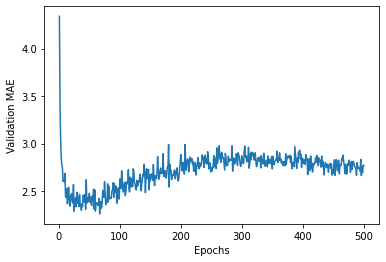

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history) 
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

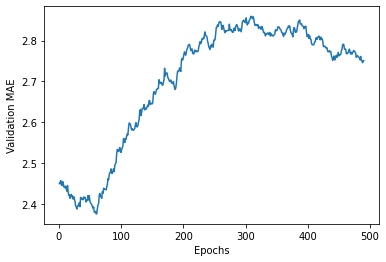

In [14]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
# We see that the loss function gets worse after epoche 80.

In [16]:
model = build_model() 
model.fit(train_data, train_targets,epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)
# TODO: how to read this data?

102/102 [==============================] - 0s 160us/step
2.675260305404663
